In [27]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense,Dropout

from keras.models import Sequential,Model
from keras.applications import NASNetMobile
from keras.applications.nasnet import preprocess_input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from pathlib import Path
import seaborn as sns

import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [28]:
traindir = '/notebooks/dataset/train/'
validdir = '/notebooks/dataset/val/'
testdir = '/notebooks/dataset/test/'

In [29]:
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))


cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')


cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()

,category,n_train,n_valid,n_test
1,glass,400,50,51
4,plastic,385,48,49
2,metal,328,41,41
0,cardboard,322,40,41
5,trash,109,13,15


In [30]:
image_size = 224
channels=3
batch_size= 128

from keras.preprocessing.image import ImageDataGenerator
#train generator
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,vertical_flip=True)
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

training_set = train_generator.flow_from_directory(
                    traindir,
                    batch_size=batch_size,
                    target_size=(image_size,image_size),
                    class_mode = 'categorical',
                    shuffle=True
                )
valid_set = valid_generator.flow_from_directory(
                    validdir,
                    target_size = (image_size,image_size),
                    batch_size=batch_size,
                    class_mode = 'categorical'
                )

Found 2019 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [31]:
base_model = NASNetMobile(include_top=False,pooling="avg")
for i,layer in enumerate(base_model.layers):
    print(i,layer)

0 <keras.engine.input_layer.InputLayer object at 0x7fdb6472a470>
1 <keras.layers.convolutional.Conv2D object at 0x7fdb6472a780>
2 <keras.layers.normalization.BatchNormalization object at 0x7fdb6473d9e8>
3 <keras.layers.core.Activation object at 0x7fdb6473d7b8>
4 <keras.layers.convolutional.Conv2D object at 0x7fdb6473dac8>
5 <keras.layers.normalization.BatchNormalization object at 0x7fdb6464f0b8>
6 <keras.layers.core.Activation object at 0x7fdb645c6208>
7 <keras.layers.core.Activation object at 0x7fdb64422cc0>
8 <keras.layers.convolutional.ZeroPadding2D object at 0x7fdb645c6908>
9 <keras.layers.convolutional.ZeroPadding2D object at 0x7fdb643b3cc0>
10 <keras.layers.convolutional.SeparableConv2D object at 0x7fdb645c64e0>
11 <keras.layers.convolutional.SeparableConv2D object at 0x7fdb64422908>
12 <keras.layers.normalization.BatchNormalization object at 0x7fdb64520c18>
13 <keras.layers.normalization.BatchNormalization object at 0x7fdb642f0ef0>
14 <keras.layers.core.Activation object at 0x7f

In [32]:

x=base_model.output
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.3)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
x = Dropout(0.3)(x)
preds=Dense(6,activation='softmax')(x) 

In [33]:
model=Model(inputs=base_model.input,outputs=preds)

In [34]:
for layer in model.layers[:752]:
    layer.trainable=False
for layer in model.layers[752:]:
    layer.trainable=True

In [36]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ["accuracy"]
             )


In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [43]:
from keras.callbacks import ReduceLROnPlateau

callbacks = [EarlyStopping(monitor='val_loss',mode="min",patience=25,verbose=1),
             ModelCheckpoint("nasnet-mobile.h5",monitor='val_loss',mode="min",save_best_only=True,save_weights_only=False,verbose=1),
             ReduceLROnPlateau(monitor='loss',factor=0.1,patience=5,cooldown=2,min_lr=0.0001,verbose=1)]

hist = model.fit(training_set,
                    steps_per_epoch = sum(n_train) // batch_size,
                    epochs = 100,
                    validation_data = valid_set,
                    validation_steps = sum(n_valid) // batch_size,
                    callbacks = callbacks
                    )

Epoch 1/100
15/15 [==============================] - 7s 496ms/step - loss: 0.5118 - accuracy: 0.8218 - val_loss: 0.6660 - val_accuracy: 0.7656

Epoch 00001: val_loss improved from inf to 0.66597, saving model to nasnet-mobile.h5
Epoch 2/100
15/15 [==============================] - 7s 476ms/step - loss: 0.4525 - accuracy: 0.8350 - val_loss: 0.7842 - val_accuracy: 0.7398

Epoch 00002: val_loss did not improve from 0.66597
Epoch 3/100
15/15 [==============================] - 7s 473ms/step - loss: 0.4242 - accuracy: 0.8472 - val_loss: 0.7937 - val_accuracy: 0.7422

Epoch 00003: val_loss did not improve from 0.66597
Epoch 4/100
15/15 [==============================] - 7s 464ms/step - loss: 0.3298 - accuracy: 0.8821 - val_loss: 0.5949 - val_accuracy: 0.7967

Epoch 00004: val_loss improved from 0.66597 to 0.59493, saving model to nasnet-mobile.h5
Epoch 5/100
15/15 [==============================] - 7s 469ms/step - loss: 0.2914 - accuracy: 0.8943 - val_loss: 0.6327 - val_accuracy: 0.7656

Epoc

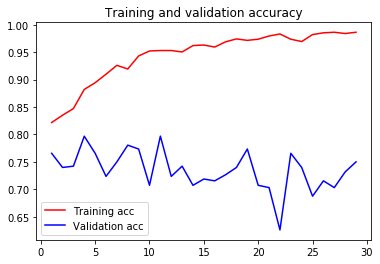

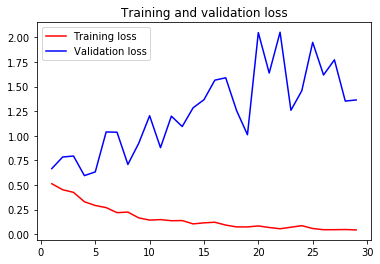

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [69]:
test_generator =  ImageDataGenerator(preprocessing_function=preprocess_input)


test_set = test_generator.flow_from_directory(
                    testdir,
                    target_size = (image_size,image_size),
                    batch_size=batch_size,
                    class_mode = 'categorical',
                    shuffle=False
                )

Found 257 images belonging to 6 classes.


In [89]:
predicted_class_indices=np.argmax(pred_test,axis=1)
labels = (test_set.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print (predictions)

['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'plastic', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'trash', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'metal', 'paper', 'cardboard', 'paper', 'cardboard', 'cardboard', 'paper', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'plastic', 'glass', 'glass', 'glass', 'glass', 'metal', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'trash', 'paper', 'trash', 'glass', 'trash', 'glass', 'glass', 'glass', 'plastic', 'glass', 'glass', 'trash', 'glass', 'glass', 'glass', 'glass', 'plastic', 'glass', 'metal', 'glass', 'metal', 'glass', 'glass', 'glass', 'glass', 'metal', 'metal', 'metal', 'met

In [91]:
test_imgs, test_labels = next(test_set)
test_labels = []
for i in range(0,int((sum(n_test)/batch_size))+1):
    test_labels.extend(np.array(test_set[i][1]))
predicted_class_indices2=np.argmax(test_labels,axis=1)
labels = (test_set.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
y = [labels2[k] for k in predicted_class_indices2]
print (y)


['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'metal'

In [79]:
!pip install scikit-learn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [121]:
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix

In [116]:
cr=classification_report(predictions,y,output_dict=True)
cm=confusion_matrix(predictions,y)

In [117]:
cr_df = pd.DataFrame(cr).transpose()
cr_df

,precision,recall,f1-score,support
cardboard,0.804878,0.846154,0.825000,39.000000
glass,0.784314,0.888889,0.833333,45.000000
metal,0.756098,0.815789,0.784810,38.000000
paper,0.800000,0.827586,0.813559,58.000000
plastic,0.795918,0.847826,0.821053,46.000000
trash,0.733333,0.354839,0.478261,31.000000
accuracy,0.785992,0.785992,0.785992,0.785992
macro avg,0.779090,0.763514,0.759336,257.000000
weighted avg,0.782730,0.785992,0.775404,257.000000


In [118]:
cm

array([[33,  0,  0,  4,  1,  1],
       [ 0, 40,  2,  0,  3,  0],
       [ 1,  3, 31,  1,  1,  1],
       [ 5,  1,  2, 48,  1,  1],
       [ 1,  3,  1,  1, 39,  1],
       [ 1,  4,  5,  6,  4, 11]])

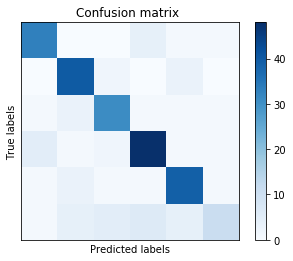

In [119]:

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

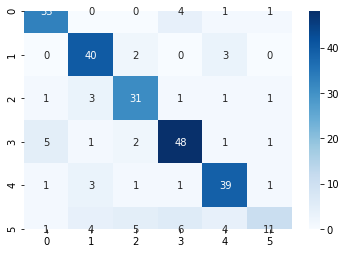

In [126]:
import seaborn as sns
cm_sns=sns.heatmap(cm, cmap='Blues', annot=True)

In [127]:
cm_sns.savefig("cm.png")

AttributeError: 'AxesSubplot' object has no attribute 'savefig'